In [6]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 84825


In [8]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [11]:
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"
class_names = ['AD', 'CN', 'MCI']
total_images = 0

for class_name in class_names:
    path = os.path.join(base_dir, class_name, 'axial')
    if os.path.exists(path):
        num_files = len([f for f in os.listdir(path) if f.lower().endswith('.png')])
        print(f"{class_name} axial images: {num_files}")
        total_images += num_files
    else:
        print(f" Path not found: {path}")

print("Total axial images:", total_images)


AD axial images: 17575
CN axial images: 25795
MCI axial images: 41455
Total axial images: 84825


In [43]:
! pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 2.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00ta 0:00:01


In [14]:
import os
import numpy as np
from tqdm import tqdm
import imgaug.augmenters as iaa
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
# from tensorflow.keras.applications import DenseNet121.  # densenet code
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import torchvision.transforms as T

# Extracting CLIP Image features
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=device)

# Define your own compatible augmentations
augmenter = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # CLIP normalization
])

# EfficientNet base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
# # Step 3: Build feature extractor model (outputs 256-dim feature vectors)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# feature_extractor = Model(inputs=base_model.input, outputs=x)

# Step 4: Setup paths and label mapping
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

features, labels, image_paths = [], [], []

# Step 5: Loop through dataset and extract features
for cls in classes:
    print(cls)
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    for fname in tqdm(os.listdir(class_dir), desc=f"Processing {cls}"):
        if fname.lower().endswith('.png'):
            img_path = os.path.join(class_dir, fname)
            try:
                pil_img = Image.open(img_path).convert("RGB")
                
                # --------- Original Image ---------
                orig_img = preprocess_clip(pil_img).unsqueeze(0).to(device)
                with torch.no_grad():
                    orig_feat = model.encode_image(orig_img).cpu().numpy().flatten()
                features.append(orig_feat)
                labels.append(label_map[cls])
                image_paths.append(img_path)

                # --------- Augmented Image ---------
                aug_img_tensor = augmenter(pil_img).unsqueeze(0).to(device)
                with torch.no_grad():
                    aug_feat = model.encode_image(aug_img_tensor).cpu().numpy().flatten()
                features.append(aug_feat)
                labels.append(label_map[cls])
                image_paths.append(img_path + "_aug")

            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

# Step 6: Save features, labels, and paths
features = np.array(features)
labels = np.array(labels)
image_paths = np.array(image_paths)

np.save("train_features_axial.npy", features)
np.save("train_labels_axial.npy", labels)
np.save("train_image_paths_axial.npy", image_paths)

print("Feature vectors saved:")
print("train_features_axial.npy")
print("train_labels_axial.npy")
print("train_image_paths_axial.npy")

AD


Processing AD: 100%|██████████| 17575/17575 [18:58<00:00, 15.44it/s]


CN


Processing CN: 100%|██████████| 25795/25795 [3:27:01<00:00,  2.08it/s]     


MCI


Processing MCI: 100%|██████████| 41455/41455 [55:53<00:00, 12.36it/s]   


Feature vectors saved:
train_features_axial.npy
train_labels_axial.npy
train_image_paths_axial.npy


same process as above for validation data

In [16]:
import os
import numpy as np
from tqdm import tqdm
import imgaug.augmenters as iaa
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
# from tensorflow.keras.applications import DenseNet121.  # densenet code
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import torchvision.transforms as T

# Extracting CLIP Image features
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=device)

# Define your own compatible augmentations
augmenter = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # CLIP normalization
])


# EfficientNet ase model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
# # Step 3: Build feature extractor model (outputs 256-dim feature vectors)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# feature_extractor = Model(inputs=base_model.input, outputs=x)

# Step 4: Setup paths and label mapping
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/val"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

features, labels, image_paths = [], [], []

# Step 5: Loop through dataset and extract features
for cls in classes:
    print(cls)
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    for fname in tqdm(os.listdir(class_dir), desc=f"Processing {cls}"):
        if fname.lower().endswith('.png'):
            img_path = os.path.join(class_dir, fname)
            try:
                img = preprocess_clip(Image.open(img_path)).unsqueeze(0).to(device)
                with torch.no_grad():
                    feat = model.encode_image(img)
                    feat = feat.cpu().numpy().flatten()
                features.append(feat)
                labels.append(label_map[cls])
                image_paths.append(img_path)
            except Exception as e:
                print(f"Failed: {img_path}, {e}")

# Step 6: Save features, labels, and paths
features = np.array(features)
labels = np.array(labels)
image_paths = np.array(image_paths)

np.save("val_features_axial.npy", features)
np.save("val_labels_axial.npy", labels)
np.save("val_image_paths_axial.npy", image_paths)

print("Feature vectors saved:")
print("val_features_axial.npy")
print("val_labels_axial.npy")
print("val_image_paths_axial.npy")

AD


Processing AD: 100%|██████████| 1870/1870 [00:57<00:00, 32.33it/s]


CN


Processing CN: 100%|██████████| 2585/2585 [01:20<00:00, 32.01it/s]


MCI


Processing MCI: 100%|██████████| 3960/3960 [02:03<00:00, 32.17it/s]

Feature vectors saved:
val_features_axial.npy
val_labels_axial.npy
val_image_paths_axial.npy


In [58]:
import os
import numpy as np

batch_dir = "features_batches_axial"
counts = {'AD': 0, 'CN': 0, 'MCI': 0}
label_map = {0: 'AD', 1: 'CN', 2: 'MCI'}

for file in sorted(os.listdir(batch_dir)):
    if file.startswith("labels_") and file.endswith(".npy"):
        labels = np.load(os.path.join(batch_dir, file))
        for label in labels:
            class_name = label_map[int(label)]
            counts[class_name] += 1

print(" Processed image counts per class:")
for cls in counts:
    print(f"{cls}: {counts[cls]} images extracted")


FileNotFoundError: [Errno 2] No such file or directory: 'features_batches_axial'

In [ ]:
! ping storage.googleapis.com

In [ ]:
import os
import numpy as np

# Directory containing all feature batches
batch_dir = "features_batches_axial"

# Initialize full arrays
all_features, all_labels, all_paths = [], [], []

# Get sorted list of batch files (based on index number)
batch_indices = sorted([
    int(f.split("_")[1].split(".")[0])
    for f in os.listdir(batch_dir) if f.startswith("features_")
])

print(f" Merging {len(batch_indices)} batches...")

# Load and concatenate each batch
for idx in batch_indices:
    f_feat = os.path.join(batch_dir, f"features_{idx}.npy")
    f_lbls = os.path.join(batch_dir, f"labels_{idx}.npy")
    f_paths = os.path.join(batch_dir, f"paths_{idx}.npy")

    features = np.load(f_feat)
    labels = np.load(f_lbls)
    paths = np.load(f_paths)

    all_features.append(features)
    all_labels.append(labels)
    all_paths.append(paths)

#  Stack everything
all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)
all_paths = np.concatenate(all_paths)

# Save final merged files
np.save("train_features_axial.npy", all_features)
np.save("train_labels_axial.npy", all_labels)
np.save("train_image_paths_axial.npy", all_paths)

print(" Merge complete!")
print(f" Total feature vectors: {all_features.shape[0]}")
print(f" Feature shape per image: {all_features.shape[1]}")


In [17]:
features = np.load("train_features_axial.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("train_labels_axial.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("train_image_paths_axial.npy") # Shape: (84755,)
print(image_paths.shape)


(169650, 512)
(169650,)
(169650,)


loading and printing features and other things for validation data as well

In [18]:
features = np.load("val_features_axial.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("val_labels_axial.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("val_image_paths_axial.npy") # Shape: (84755,)
print(image_paths.shape)


(8415, 512)
(8415,)
(8415,)


In [22]:
# Load the .npy files
import pandas as pd
features = np.load("train_features_axial.npy")       # Shape: (84755, 256)
labels = np.load("train_labels_axial.npy")           # Shape: (84755,)

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (84755, 257)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns

feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("train_axial_features_and_labels_only.csv", index=False)

print(" Saved: train_axial_features_and_labels_only.csv")


 Saved: train_axial_features_and_labels_only.csv


same process for validation set

In [23]:
# Load the .npy files
features = np.load("val_features_axial.npy")       # Shape: (84755, 256)
labels = np.load("val_labels_axial.npy")           # Shape: (84755,)

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (84755, 257)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns
feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("val_axial_features_and_labels_only.csv", index=False)

print(" Saved: val_axial_features_and_labels_only.csv")


 Saved: val_axial_features_and_labels_only.csv


In [24]:
# for text embeddings
import pandas as pd

# Load your file
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Complete_1Yr_1.5T_12_20_2024.csv")

# Preview the first few rows
print(df.shape)
df.head()


(2294, 12)


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,12/07/2024
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,12/07/2024
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,12/07/2024
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,12/07/2024
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,12/07/2024


In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("ADNI1_Complete_1Yr_1.5T_12_20_2024.csv")

# Remove label 
df_cleaned = df.drop(columns=["Group", "Downloaded", "Modality", "Type", "Format"])

# Keep Image ID separately for future mapping
image_ids = df_cleaned["Image Data ID"].values

# Drop ID from the text encoding input
text_only = df_cleaned.drop(columns=["Image Data ID"])

# Convert each row to string and generate sentence embeddings
texts = text_only.astype(str).agg(" ".join, axis=1).tolist()


# Join text per row
texts = text_only.astype(str).agg(" ".join, axis=1).tolist()

# Tokenize all text using CLIP
text_tokens = clip.tokenize(texts).to(device)

# Generate text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()  # shape: (n_samples, 512)
# Save with Image IDs
import numpy as np
np.save("text_embeddings_cleaned.npy", text_embeddings)
np.save("text_image_ids.npy", image_ids)


In [30]:
import numpy as np
import pandas as pd

# Load the cleaned text embeddings and associated image IDs
text_embeddings = np.load("text_embeddings_cleaned.npy")           # shape: (2294, 384)
text_image_ids = np.load("text_image_ids.npy", allow_pickle=True)  # shape: (2294,)

# Convert to DataFrame and add IDs as the first column
df = pd.DataFrame(text_embeddings)
df.insert(0, "Image_ID", text_image_ids)

# Save to CSV
df.to_csv("text_embeddings_cleaned_with_ids.csv", index=False)

print(" Saved: text_embeddings_cleaned_with_ids.csv")
print(" Shape:", df.shape)


 Saved: text_embeddings_cleaned_with_ids.csv
 Shape: (2294, 513)


In [31]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("train_features_axial.npy")       # (84755, 256)
image_labels = np.load("train_labels_axial.npy")           # (84755,)
image_paths = np.load("train_image_paths_axial.npy")       # (84755,)

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("train_fused_features_clean.npy", fused_features)
np.save("train_fused_labels_clean.npy", fused_labels)

print(" Final train fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 169650/169650 [00:00<00:00, 408388.86it/s]


 Matched samples: 169650
 Final train fused shape: (169650, 1024)
 Labels shape: (169650,)


fusion for the validation set is done below

In [32]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("val_features_axial.npy")       # (84755, 256)
image_labels = np.load("val_labels_axial.npy")           # (84755,)
image_paths = np.load("val_image_paths_axial.npy")       # (84755,)

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_clean.npy", fused_features)
np.save("val_fused_labels_clean.npy", fused_labels)

print(" Final val fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 8415/8415 [00:00<00:00, 254223.13it/s]

 Matched samples: 8415
 Final val fused shape: (8415, 1024)
 Labels shape: (8415,)


In [33]:
import numpy as np
import pandas as pd

# Load
X = np.load("train_fused_features_clean.npy")
y = np.load("train_fused_labels_clean.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("train_fused_embeddings_with_labels.csv", index=False)
print(" Saved: train_fused_embeddings_with_labels.csv")


 Saved: train_fused_embeddings_with_labels.csv


savinf into csv the validation fused sets

In [34]:
import numpy as np
import pandas as pd

# Load
X = np.load("val_fused_features_clean.npy")
y = np.load("val_fused_labels_clean.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("val_fused_embeddings_with_labels.csv", index=False)
print(" Saved: val_fused_embeddings_with_labels.csv")


 Saved: val_fused_embeddings_with_labels.csv


saving image and textual data separately for training dataset

In [35]:
import numpy as np

# Load fused embeddings
fused = np.load("train_fused_features_clean.npy")  # (84755, 640)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # Sentence-transformer-based

# Save separately
np.save("train_image_features_only.npy", image_features)
np.save("train_text_features_only.npy", text_features)

print(" Saved:")
print("  train_image_features_only.npy (shape:", image_features.shape, ")")
print("  train_text_features_only.npy  (shape:", text_features.shape, ")")


 Saved:
  train_image_features_only.npy (shape: (169650, 256) )
  train_text_features_only.npy  (shape: (169650, 768) )


saving image and textual data separately for validation dataset

In [36]:
import numpy as np

# Load fused embeddings
fused = np.load("val_fused_features_clean.npy")  # (84755, 640)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # Sentence-transformer-based

# Save separately
np.save("val_image_features_only.npy", image_features)
np.save("val_text_features_only.npy", text_features)

print(" Saved:")
print("  val_image_features_only.npy (shape:", image_features.shape, ")")
print("  val_text_features_only.npy  (shape:", text_features.shape, ")")


 Saved:
  val_image_features_only.npy (shape: (8415, 256) )
  val_text_features_only.npy  (shape: (8415, 768) )


the code below is added just to save the progress

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Step 1: Load training set fused features and labels
X_train = np.load("train_fused_features_clean.npy")   # Shape: (84755, 640)
y_train = np.load("train_fused_labels_clean.npy")     # Shape: (84755,)

# Step 2: Load validation set fused features and labels
X_val = np.load("val_fused_features_clean.npy")
y_val = np.load("val_fused_labels_clean.npy")

# 🔹 Step 2: Train/test split (not used for testing file)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# 🔹 Step 3: Define and train MLP (no need of fitting again in test set)
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 64),   # You can adjust the architecture
    activation='relu',
    learning_rate_init=0.0006,
    solver='adam',
    max_iter=50,          # Increase to 100–300 for better results if time allows
    random_state=42,
    verbose=True
)
mlp.fit(X_train, y_train)

# 🔹 Step 4: Predict and evaluate
y_pred = mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n MLP Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["AD", "CN", "MCI"]))

# 🔹 Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(" Confusion Matrix - MLP (Fused Features)")
plt.tight_layout()
plt.show()


In [37]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

NameError: name 'y_train' is not defined

In [20]:
import torch.nn as nn

class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1024, 512),   # input size must match your fused feature size (e.g., 1024 if CLIP image+text)
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3)       # 3 output classes (AD, CN, MCI)
        )

    def forward(self, x):
        return self.net(x)

Epoch 1/10, Loss: 0.5824
Epoch 2/10, Loss: 0.1643
Epoch 3/10, Loss: 0.0813
Epoch 4/10, Loss: 0.0514
Epoch 5/10, Loss: 0.0387
Epoch 6/10, Loss: 0.0311
Epoch 7/10, Loss: 0.0259
Epoch 8/10, Loss: 0.0218
Epoch 9/10, Loss: 0.0196
Epoch 10/10, Loss: 0.0182
📊 Training Accuracy: 1.0000
✅ Validation Accuracy: 0.6671
Classification Report:
               precision    recall  f1-score   support

          AD       0.71      0.57      0.63      1870
          CN       0.62      0.61      0.61      2585
         MCI       0.68      0.75      0.71      3960

    accuracy                           0.67      8415
   macro avg       0.67      0.64      0.65      8415
weighted avg       0.67      0.67      0.67      8415



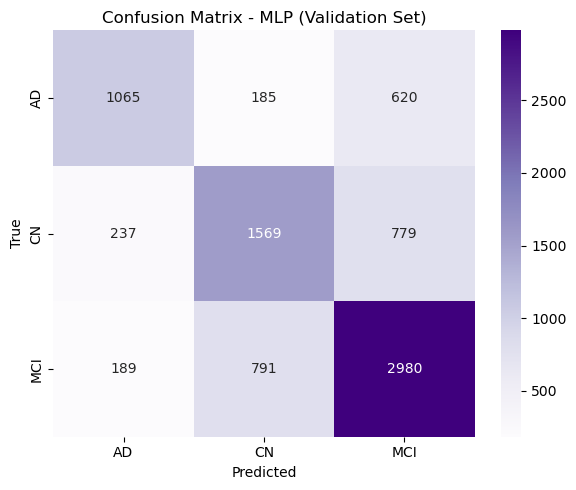

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch.nn as nn
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Load data
X_train = np.load("train_fused_features_clean.npy")
y_train = np.load("train_fused_labels_clean.npy")
X_val = np.load("val_fused_features_clean.npy")
y_val = np.load("val_fused_labels_clean.npy")

# Optional: if your MLP has 1024 input, pad image/text features accordingly
# assert X_train.shape[1] == 1024

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



model = MLPWithDropout().to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
import gc
gc.collect()
torch.cuda.empty_cache()

# 🔹 Evaluate on Training Set
model.eval()
y_train_preds = []
y_train_true = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

# Training Metrics
train_acc = accuracy_score(y_train_true, y_train_preds)
print(f"📊 Training Accuracy: {train_acc:.4f}")

# 🔹 Evaluate on Validation Set
model.eval()
y_val_preds = []
y_val_true = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_val_preds.extend(preds.cpu().numpy())
        y_val_true.extend(yb.numpy())

# Metrics
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["AD", "CN", "MCI"]))

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming y_test and y_pred are already defined from your previous evaluation

# Define class labels (you can update these if your label encoding is different)
class_names = ['AD', 'CN', 'MCI']

# Accuracy
accuracy = accuracy_score(y_val_true, y_val_preds)
print(f"\n Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
print("\n Classification Report:")
print(classification_report(y_val_true, y_val_preds, target_names=class_names))



 Accuracy: 0.6765

 Classification Report:
              precision    recall  f1-score   support

          AD       0.71      0.57      0.63      1870
          CN       0.64      0.60      0.62      2585
         MCI       0.69      0.78      0.73      3960

    accuracy                           0.68      8415
   macro avg       0.68      0.65      0.66      8415
weighted avg       0.68      0.68      0.67      8415

